In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import mesa
from mesa import Model
from mesa import Agent
from mesa.datacollection import DataCollector

In [2]:
import sys
sys.version_info

sys.version_info(major=3, minor=12, micro=7, releaselevel='final', serial=0)

In [3]:
from scipy.optimize import minimize
import numpy as np

def log_likelihood(params, X, y, private_modes, public_modes):
    lambda_private, lambda_public = params
    loglik = 0.0

    for features, choice in zip(X, y):
        utilities = compute_utilities(features)  # your U_i dictionary
        if choice in private_modes:
            lam = lambda_private
            nest = private_modes
        else:
            lam = lambda_public
            nest = public_modes

        denom = sum(np.exp(utilities[m]/lam) for m in nest)
        prob = np.exp(utilities[choice]/lam) / denom
        loglik += np.log(prob + 1e-10)  # add epsilon to avoid log(0)
    
    return -loglik  # minimize negative log-likelihood

# Initial guess and run
res = minimize(log_likelihood, x0=[0.5, 0.5], args=(X, y, private_modes, public_modes), bounds=[(0.01, 5), (0.01, 5)])


NameError: name 'X' is not defined

In [4]:
from scipy.stats import lognorm
#using philadelphia data
distance_mean = 8.3
distance_std = 5.7

lognorm_mu = np.log(distance_mean**2 / np.sqrt(distance_std**2 + distance_mean**2))
lognorm_sigma = np.sqrt(np.log(1 + (distance_std**2 / distance_mean**2)))
print(lognorm_mu)
print(lognorm_sigma)


1.923073113083003
0.621582499302465


In [6]:
#using philadelphia data
mean_income = 88000
income_min = 5000
pareto_alpha = mean_income / (mean_income - income_min)
print(pareto_alpha)

1.0602409638554218


In [9]:
hourly_wage = mean_income / 2080  # 2080 work hours/year
time_value = 0.5 * hourly_wage
print(time_value)

21.153846153846153


In [102]:
class CommuterAgent(Agent):

    def __init__(self, model, socio_group, income, car_owner, price_sensitivity, lambda_list):
        super().__init__(model)
        self.socio_group = socio_group
        self.income = income
        self.car_owner = car_owner
        self.price_sensitivity = price_sensitivity
        self.mode_choice = None

    def say_hi(self):
        print(f"Hi, I am an agent, you can call me {self.unique_id!s}.")

    def step(self):
        utilities = self.calculate_utilities()
        self.mode_choice = self.choose_mode(utilities)

    def calculate_utilities(self):

        utilities = {}
        utilities['car'] = (10 if self.car_owner else -np.inf) - self.price_sensitivity * (self.model.car_cost + self.model.car_toll) - \
                            0.5 * self.model.congestion_level
        utilities['bus'] = 6.0 - self.price_sensitivity * (self.model.bus_cost * (1.0 - self.model.fare_discount)) - \
                            0.3 * self.model.congestion_level
        utilities['train'] = 8.0 - self.price_sensitivity * (self.model.train_cost * (1.0 - self.model.fare_discount))
        utilities['bike_walk'] = 5.0 - 0.7 * self.model.distance_factor

        return utilities

    def choose_mode(self, utilities):
        lambda_private = lambda_list[0]
        lambda_public = lambda_list[1]
        private_modes = ['car', 'bike_walk']
        public_modes = ['bus', 'train']

        exp_private = sum([np.exp(utilities[m]/self.model.lambda_private) for m in private_modes])
        exp_public = sum([np.exp(utilities[m]/self.model.lambda_public) for m in public_modes])

        nest_private = self.model.lambda_private * np.log(exp_private)
        nest_public = self.model.lambda_public * np.log(exp_public)

        prob_private = np.exp(nest_private) / (np.exp(nest_private) + np.exp(nest_public))
        prob_public = 1-prob_private

        if np.random.rand() < prob_private:
            chosen_mode = np.random.choice(private_modes, p=[np.exp(utilities[m]/self.model.lambda_private)/exp_private for m in private_modes])
        else:
            chosen_mode = np.random.choice(public_modes, p=[np.exp(utilities[m]/self.model.lambda_public)/exp_public for m in public_modes])

        return chosen_mode

In [103]:
class TransportModel(Model):
    def __init__(self, num_agents, fare_discount, car_toll, trans_cost, lambda_list, road_capacity, width=10, height=10, seed = None):
        super().__init__(seed=seed)
        self.num_agents = num_agents
        self.fare_discount = fare_discount
        self.car_toll = car_toll
        self.width = width
        self.height = height

        self.car_cost = trans_cost[0]
        self.bus_cost = trans_cost[1]
        self.train_cost = trans_cost[2]
        
        self.distance_factor = 1.0

        self.lambda_private = lambda_list[0]
        self.lambda_public = lambda_list[1]

        self.road_capacity = road_capacity

        self.congestion_level = 1.0

        rng = self.random
        socio_groups = []
        incomes = []
        car_ownerships = []
        sensitivities = []

        for _ in range(num_agents):
            r = rng.random()
            if r < 0.3:
                socio_groups.append('low')
                incomes.append(30000)
                car_ownerships.append(rng.random() < 0.4)
                sensitivities.append(1.0)
            elif r < 0.8:
                socio_groups.append('middle')
                incomes.append(65000)
                car_ownerships.append(rng.random() < 0.7)
                sensitivities.append(0.6)
            else:
                socio_groups.append('high')
                incomes.append(120000)
                car_ownerships.append(rng.random() < 0.9)
                sensitivities.append(0.3)

        # Batch-create agents
        CommuterAgent.create_agents(
            model=self,
            n=num_agents,
            socio_group=socio_groups,
            income=incomes,
            lambda_list=lambda_list,
            car_owner=car_ownerships,
            price_sensitivity=sensitivities
        )

        self.datacollector = DataCollector(
            model_reporters = {"Congestion": "congestion_level"},
            agent_reporters = {"Mode": "mode_choice"}
        )

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.agents.shuffle_do("step")
        self.update_congestion()
        self.datacollector.collect(self)

    def update_congestion(self):
        cars = sum(1 for a in self.agents if a.mode_choice == 'car')
        v_over_c = cars / self.road_capacity
        self.congestion_level = 1 + 0.15 * (v_over_c) ** 4

In [104]:
trans_cost = [5.0,2.0,3.0]
lambda_list = [0.8, 0.6]
road_capacity = 10000

model = TransportModel(num_agents=20000, fare_discount=0.05, car_toll=5.0, trans_cost = trans_cost, lambda_list = lambda_list, road_capacity = road_capacity)

# Step through a few iterations
for _ in range(50):
    model.step()

# Extract Data
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe().reset_index()


Cannot show ipywidgets in text

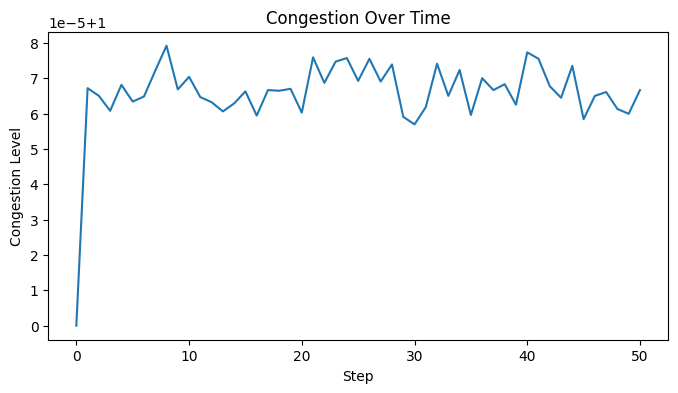

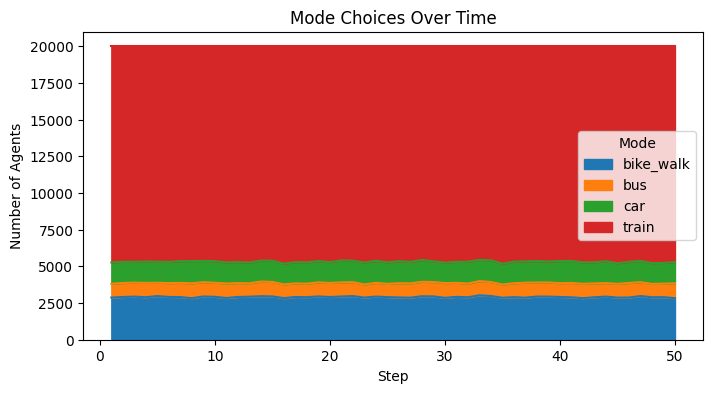

In [105]:
import solara
import matplotlib.pyplot as plt
import pandas as pd

@solara.component
def TransportDashboard():
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    model_df["Congestion"].plot(ax=ax1)
    ax1.set_title("Congestion Over Time")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Congestion Level")

    fig2, ax2 = plt.subplots(figsize=(8, 4))
    mode_counts = agent_df.groupby(["Step", "Mode"]).size().unstack(fill_value=0)
    mode_counts.plot.area(ax=ax2, stacked=True)
    ax2.set_title("Mode Choices Over Time")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Number of Agents")

    solara.display(fig1)
    solara.display(fig2)

TransportDashboard()
